# Exploring Source Data

The purpose of this notebook is to investigate a single source file to determine what is necessary for initialization and eventually, artifact rejection.

For instructive purposes, this notebook may be run in various orders to demonstrate how various functions behave.

The browser backend call below is a secondary type of import that allows for interactive and responsive figures.

In [20]:
import mne
mne.viz.set_browser_backend('qt') # Use the fancier figures when possible

'qt'

In the following code cell the variable `subject_file` is being used to point to a BDF file in the `sourcedata` directory.

For exploring your own data, change `IC_trn_1.bdf' to your own file.

In [21]:
subject_file = '../sourcedata/IC_trn_1.bdf' # See description above
raw = mne.io.read_raw(subject_file, preload=True) # Load the defined subject
raw # Last variable in a cell "spills" to the output

Extracting EDF parameters from /home/tyler/Documents/eeg-dev/StudyTemplate/sourcedata/IC_trn_1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 280575  =      0.000 ...   273.999 secs...


<RawEDF | IC_trn_1.bdf, 129 x 280576 (274.0 s), ~276.2 MB, data loaded>

This stage should be used to confirm that the above cell has printed out what you expect from your data.

Some import thinks to check that should match expectations:

* Sampling rate
* Duration
* Channel count

However in the case of the sample data, there are some things that need to be fixed:

* Filtering
* Montage
* Reference

Filtering is easily done via the following code block. Change `l_freq` and `h_freq' to suit your needs. If you are interested in a notch filter, an example is provided in the same cell, just commented out.

In [22]:
raw = raw.filter(l_freq=1.0, h_freq=30.0)
# raw = raw.notch_filter(60) # Filter out power line frequency

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3381 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s


Next, we can tackle montages. MNE as a rule supports several different builtin montages that you can load without having to provide a file defining channel locations. They can be viewed as follows:

In [23]:
mne.channels.get_builtin_montages()

['standard_1005',
 'standard_1020',
 'standard_alphabetic',
 'standard_postfixed',
 'standard_prefixed',
 'standard_primed',
 'biosemi16',
 'biosemi32',
 'biosemi64',
 'biosemi128',
 'biosemi160',
 'biosemi256',
 'easycap-M1',
 'easycap-M10',
 'easycap-M43',
 'EGI_256',
 'GSN-HydroCel-32',
 'GSN-HydroCel-64_1.0',
 'GSN-HydroCel-65_1.0',
 'GSN-HydroCel-128',
 'GSN-HydroCel-129',
 'GSN-HydroCel-256',
 'GSN-HydroCel-257',
 'mgh60',
 'mgh70',
 'artinis-octamon',
 'artinis-brite23',
 'brainproducts-RNP-BA-128']

If you data happens to be recorded using one of these, you can simply set the montage as in the cell below. The `raw.plot_sensors()` call is used to make sure that all location match the placement scheme.

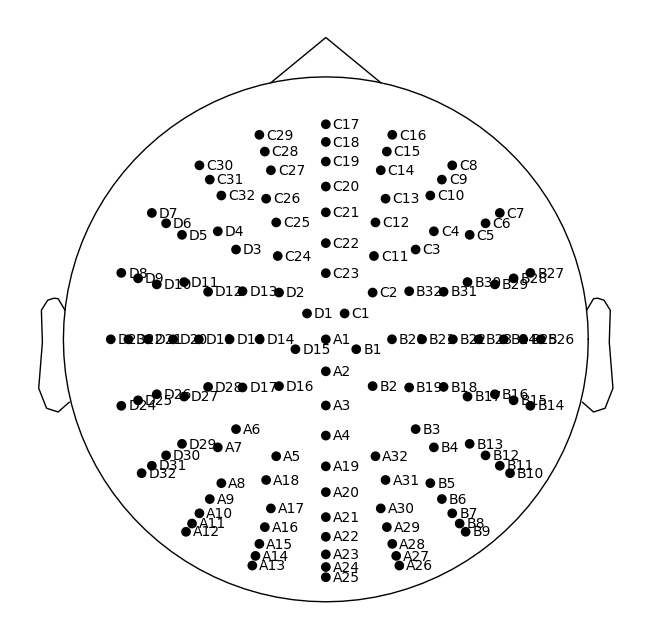

In [24]:
%matplotlib inline
# "magic" cell command, this one keeps the plots in the notebook instead of popping up
raw = raw.set_montage('biosemi128')
_ = raw.plot_sensors(show_names=True)

If your recording montage does not necessarily fit into one of the standards here are some suggestions with code snippets:

* If you have EOG channels, make sure to set their type to `eog` via `raw.set_channel_types` which is documented [here](https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.set_channel_types)
* If there a channels you will not be able to provide information for, or would like to ignore, you can change the behaviour of set montage with the `on_missing` paramater documented [here](https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.set_montage)
  * There are also parameters for matching upper/lower case. Some machines record things as `FPZ`, `fpz`, `FPz`, etc.
* If you have your own specific scheme you would like to load from a file, please see the below code snippet. This assumes that the file is in the same directory as the notebook.

```python
custom_montage = mne.channels.read_custom_montage('custom_montage.elp')
raw = raw.set_montage(custom_montage)
```

Lastly, setting the reference can be quite simple. Below the recording is set to the average reference. In the same code cell are other common reference approaches that can be switched in for another data set.

In [25]:
raw = raw.set_eeg_reference('average')

# use a single channel reference (left earlobe)
# raw = raw.set_eeg_reference(ref_channels=['A1'])

# use average of mastoid channels as reference
# raw = raw.set_eeg_reference(ref_channels=['M1', 'M2']) # Make sure these exist in your montage!!

# use a bipolar reference (contralateral)
# raw.set_bipolar_reference(anode='[F3'], cathode=['F4']) # Make sure these exist in your montage!!

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


At this point, the data is ready for visual inspection to make sure there are not numerous artifacts, or other issues present.

This can be done by the following:

* Checking what MNE understands of the recording in the `raw` variable
* Calculating and viewing the power spectral density to make sure known properties exist
* Plotting the actual scalp data and looking for problems

Starting with the raw object:

In [26]:
raw

<RawEDF | IC_trn_1.bdf, 129 x 280576 (274.0 s), ~276.3 MB, data loaded>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).


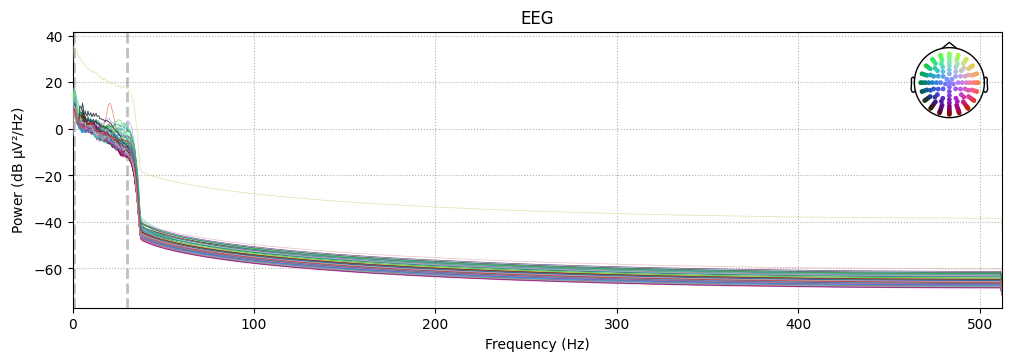

In [27]:
%matplotlib qt
raw.plot_psd() # Computes the psd implicitly

This plot helpfully reveals that `C10` is going to be problematic in the future.

In [28]:
%matplotlib qt
raw.plot()

Channels marked as bad:
none


We can confirm now via the scrollplot that `C10` is indeed bad. This can be marked as bad inside of the scrollplot or manually set as bad during other steps in preprocessing.

This concludes preparing the data for inspection, and allows a researcher to make decisions about the quality of the recording.

Subsequent sections of this notebook are spent epoching, and briefly cleaning the data to confirm that the subject was attending to the experiment.

### Exploring Epochs

There are two ways that MNE can extract events from files. Either via dedicated stim channels, or "annotations".

This example describes stim channels. As such, the `event_dict` must be manually input. These are your standard pin/markers.

In [ ]:
# event_dict = {"boundary": 65791, "anim/house/upright/f1": 11, "anim/house/upright/f2": 12, "anim/house/upright/f3": 13, "anim/house/upright/f4": 14, "anim/house/upright/f5": 15, "anim/house/upright/f6": 16, "anim/face/upright/f1": 31, "anim/face/upright/f2": 32, "anim/face/upright/f3": 33, "anim/face/upright/f4": 34, "anim/face/upright/f5": 35, "anim/face/upright/f6": 36, "house/inverted/f1": 21, "anim/house/inverted/f2": 22, "anim/house/inverted/f3": 23, "anim/house/inverted/f4": 24, "anim/house/inverted/f5": 25, "anim/house/inverted/f6": 26, "anim/checker/f1": 51, "anim/checker/f2": 52, "anim/checker/f3": 53, "anim/checker/f4": 54, "anim/checker/f5": 55, "anim/checker/f6": 56, "anim/face/inverted/f1": 41, "anim/face/inverted/f2": 42, "anim/face/inverted/f3": 43, "anim/face/inverted/f4": 44, "anim/face/inverted/f5": 45, "anim/face/inverted/f6": 46, "static/checker/left": 215, "press/left": 201, "static/checker/right": 216, "press/right": 204, "static/face/upright": 211, "static/face/inverted": 212, "static/house/upright": 213, "static/house/inverted": 214}
event_dict = {
    "static/checker/left": 215,
    "press/left": 201,
    "static/checker/right": 216,
    "press/right": 204,
    "static/face/upright": 211,
    "static/face/inverted": 212,
    "static/house/upright": 213,
    "static/house/inverted": 214,
}
events = mne.find_events(raw)
events

The format of events is always an array with three elements.

1. The sample
2. The previously seen event (can be configured to help with segmentation)
3. The marker code

If you are interested in finding breaks in your task automatically you will need to switch to the "annotations" approach. Since this example is using a single Face13 subject, there are no annotations. Here's how to generate them programmatically using the previously defined information:

In [ ]:
anno = mne.annotations_from_events(events, raw.info['sfreq'], event_desc={v:k for k,v in event_dict.items()})
raw.set_annotations(anno)

In [ ]:
break_annots = mne.preprocessing.annotate_break(
    raw=raw,
    min_break_duration=5,
    t_start_after_previous=1,
    t_stop_before_next=1,
)

raw.set_annotations(raw.annotations + break_annots)  # add to existing

In [ ]:
raw.plot()

This function is complicated to understand. I strongly recommend visiting the documentation for it and exploring the effect of parameter choices by replotting you data and seeing where it places the breaks.

See documentation [here](https://mne.tools/stable/generated/mne.preprocessing.annotate_break.html#mne.preprocessing.annotate_break).

### Extremely Quick ICA Showcase

In [ ]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=14, max_iter=800)
ica.fit(raw)
ica.exclude = [1, 2] # details on how we picked these are omitted here
ica.plot_properties(raw, picks=ica.exclude)

In [ ]:
raw = ica.apply(raw)
raw

### Finishing Epoching

If necessary, you can add channels to a list known as `bads`, which MNE will exclude by default.

Be careful however, as they may still be included in some cases. To avoid this, you can interpolate the bad channels via a function called `interpolate_bads`.

In [ ]:
raw.info['bads'].append('C10')

In [ ]:
reject_criteria = dict(
    eeg=150e-6,  # 150 µV
)

epochs = mne.Epochs(
    raw,
    events,
    event_id=event_dict,
    tmin=-0.2,
    tmax=0.6,
    reject=reject_criteria,
    preload=True,
)
epochs

In [ ]:
%matplotlib inline
epochs['face'].average().plot_joint()
_ = epochs['face'].average().plot_topomap(times=[0.0, 0.08, 0.1, 0.12, 0.2])

In [ ]:
%matplotlib inline
comparison = {
    'press': epochs['press'].average(),
    'house': epochs['house'].average(),
}
mne.viz.plot_compare_evokeds(comparison, combine='mean', picks=['A22', 'A23'])

In [ ]:
epochs['press'].to_data_frame()